In [250]:
from google.colab import drive

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import time
from scipy import special
import sympy
from scipy.optimize import fsolve


# This will prompt for authorization. This enables to load files stored in your google drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Simulation parameters

In [251]:
Nx=2048
Nz=500
Lx_=30e-6 
Lz_=100e-6
n0_=1.5
lambda0_=800e-9

delta_   = 1.0			   # normalization parameter 
# Physical constants
mu0 = 4.0e-7 * np.pi    # free space magnetic permeability [Vs/Am]
c0  = 2.99792458e+8     # free space light speed [m/s]
epsilon0 = 1.0 / (mu0 * c0**2)         # free space permittivity [As/Vm]
eta0     = np.sqrt(mu0 / epsilon0)    # free space impedance [ohm]

# Derived parameters

k0_     = 2 * np.pi / lambda0_       		# free space wavenumber [m-1]
k_ = n0_ * k0_            						  # medium wavenumber [m-1]
lambda_ = lambda0_ / n0_                # medium wavelength [m]

# Normalization coefficients
# The equation can be normalized to a dimensionless form
# spatial normalization factor in the x-y plane
spatial_transverse_scale = 1/(k0_ * np.sqrt(2 * n0_ *  delta_))
# spatial normalization factor in the z direction
spatial_longitudinal_scale = 1/(delta_ * k0_)

scale_ratio = spatial_longitudinal_scale/spatial_transverse_scale  # = sqrt(2*n0_/delta_)
  # normalization factor for the electric field


  # ************* Normalized parameters *************
Lx = Lx_ / spatial_transverse_scale                # normalized model width
Lz = Lz_ / spatial_longitudinal_scale              # normalized propagation distance
k  = 2*np.pi * spatial_transverse_scale / lambda_  # normalized light k-vector

  # ************ Numeric model parameters ***********
dx_ = Lx_/Nx                                                                # normalized discretization step in x
dx  = Lx/Nx                                                             # discretization step in x
x_  = dx_ * np.arange(-Nx/2,Nx/2,1)                                         # x dimension vector
x   = dx  * np.arange(-Nx/2,Nx/2,1)                                     # normalized x dimension vector
dkx = 2*np.pi/Lx                                                            # discretization in the spatial spectral domain along the y direction
kx  = dkx * np.concatenate((np.arange(0,Nx/2,1),np.arange(-Nx/2,0,1)))     	# spatial frequencies vector in the x direction (swapped)

dz  = Lz/Nz
dz_ = Lz_/Nz
z   = dz * np.arange(1,Nz+1,1) 
z_  = dz_* np.arange(1,Nz+1,1) 

K2=kx**2

nonlinearity = 0 
absorbing_boundary=1
window = np.exp(-(x_/(0.5*Lx_))**20)

In [252]:
k

0.8660254037844387

#Define the waveguide

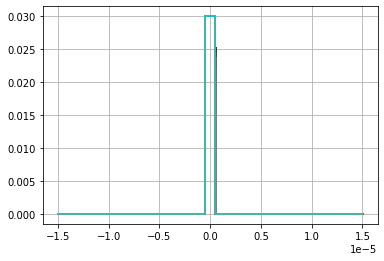

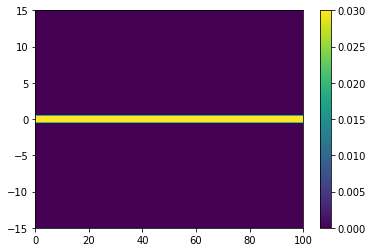

In [253]:
waveguide = np.zeros((Nx, Nz))
d=1e-6
n_core=1.53
n_clad=n0_
Length_wg=Lz_

n_diff=n_core-n_clad

NA= np.sqrt(n_core**2 - n_clad**2)
v_num = NA*(np.pi*d/lambda0_)      # V mumber of the waveguide

waveguide[(np.abs(x_)<=d/2)]=1*n_diff 

plt.plot(x_,waveguide)
plt.grid()
plt.show()

plt.imshow(waveguide,aspect='auto',extent=[0,Lz_*1e6,-Lx_/2*1e6,Lx_/2*1e6])
plt.colorbar()
plt.show()


In [254]:
clad_ind=0
while waveguide[clad_ind,0] < 0.001:
  clad_ind+=1
x_clad_1=x_[0:clad_ind]
clad_ind2=clad_ind
while waveguide[clad_ind2,0] > 0.001:
  clad_ind2+=1
x_core=x_[clad_ind:clad_ind2]
x_clad_2=x_[clad_ind2:Nx]

#Number of supported modes

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


(0.0, 10.0)

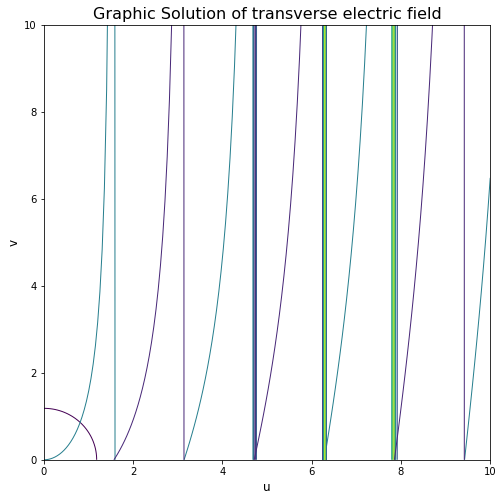

In [255]:
# Here we check how many modes are supported via V number of the waveguide.
# First hyperbolic line is TE, the second is TM and it goes like TE,TM,TE,TM,...
# IGNORE the vertical lines and do not count them for the crossings.
# The circle represents the V number curve. The crossings give the supported modes.
# In this case, we have just one crossing, meaning that we have a single mode fiber.


titleSize = 16
legendSize = 12
labelSize = 12
tickSize = 12

# Define grids in x and y dimension
v = np.linspace(0.0, 10, 200)
u = np.linspace(0.0, 10, 200)

# Span meshgrid over entire x/y plane
vv,uu = np.meshgrid(v, u)

# Evaluate function at each point in the x/y plane
V_p = vv**2 + uu**2 - v_num**2

gg = uu*np.tan(uu)-vv 
mm = -vv-uu/np.tan(uu)

fig, ax = plt.subplots(figsize=(8, 8))
CS=ax.contour(uu,vv, V_p,[0], linewidths=1)
CS=ax.contour(uu,vv, gg,  linewidths=1)
CS=ax.contour(uu,vv, mm,  linewidths=1)
ax.set_title(r'Graphic Solution of transverse electric field', fontsize=titleSize)
ax.set_xlabel('u', fontsize=labelSize)
ax.set_ylabel('v', fontsize=labelSize)
ax.set_xlim([0,10])
ax.set_ylim([0,10])


#CALCULATION OF THE PROPAGATION CONSTANTS AND THE WAVEGUIDE MODES

In [256]:
## EVEN MODES
Number = 3         # Number of iterations 
Se = np.zeros((Number,1))

fe = lambda x : np.abs(x)*np.tan(np.abs(x))-np.sqrt(v_num**2-x**2)

for n in range(Number): 
  Se[n,0] = fsolve(fe, 0.8)

Su_e = np.unique(Se)      # Unique solutions of the equation fe

up_e = Su_e               # Parameters u and v
vp_e = np.sqrt(v_num**2-up_e**2)

qp_e = 2*vp_e[0]/d;       # Wavenumbers q and h 
hp_e = 2*up_e[0]/d;

beta_ = np.sqrt((n_core * k0_)**2 - hp_e**2);

B_e = 1;
D_e = np.cos(hp_e*d/2)/np.exp(-qp_e*d/2)*B_e;
C_e = D_e;

mode_0e = np.concatenate((D_e * np.exp(qp_e * x_clad_1), B_e * np.cos(hp_e * x_core), C_e * np.exp(-qp_e * x_clad_2)),axis=0)
beam_e = mode_0e;


In [257]:
## ODD MODES
if v_num>np.pi/2:
  Number=3
  So=np.zeros((Number,1))
  fo = lambda x : np.abs(x)/(np.tan(np.abs(x)))+np.sqrt(v_num**2-x**2)
  for n in range(Number):
    So[n,0] = fsolve(fo, 0.8)
  Su_o = np.unique(So)     # Unique solutions of the equation fe

  up_o=Su_o
  vp_o=np.sqrt(v_num**2-up_o**2)

  qp_o=2*vp_o/d
  hp_o=2*up_o/d

  beta_o = np.sqrt((n_core * k0_)**2 - hp_o**2)

  B_1 = 1
  D_1 = np.sin(hp_o*d/2)/np.exp(-qp_o*d/2)*B_1
  C_1 = D_1

  mode_1 = np.concatenate((-D_1 * np.exp(qp_o * x_clad_1), B_1 * np.sin(hp_o * x_core), C_1 * np.exp(-qp_o * x_clad_2)),axis=0)
  beam_o = mode_1;



#DEFINITION OF THE INPUT FIELD

In [258]:
beam_fwhm_ = 1e-6  #1.37e-6;
beam_scale_ = beam_fwhm_ / (2*np.sqrt(np.log(2)))
gaussian_beam = np.exp(-(x_/beam_scale_)**2)

rect_input=np.zeros((Nx,))
rect_input[(np.abs(x_)<=d/2)]=1 

u = beam_e  #rect_input #gaussian_beam

In [259]:
profile=np.array(np.zeros((Nx,Nz)), dtype=complex)

t_start = time.time()
count=0
u0=u
for index_z in range(Nz):
  count=count+1
  V=waveguide[:,index_z]
  
  # Nonparaxial code
  u1 = np.fft.ifft(np.fft.fft(u0) * np.exp(-1j * K2  * dz * scale_ratio / (k + np.emath.sqrt(k**2 - K2))))
  if index_z*dz_<=Length_wg:
    u2 = u1 * np.exp(1j * dz * (nonlinearity * np.abs(u1)**2 + V))
  else:
    u2 = u1 * np.exp(1j * dz * (nonlinearity * np.abs(u1)**2 ))

  profile[:,count-1]=u2

  if absorbing_boundary==1:
    u0=u2*window
  else:
    u0=u2

# Let's store the result in a variable with a more explicit name
output = u2

t_end = time.time()
print("time elapsed:",(t_end-t_start),"seconds")

time elapsed: 0.25773191452026367 seconds


#Display results

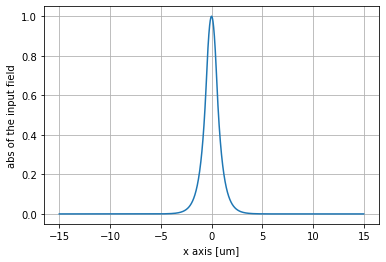

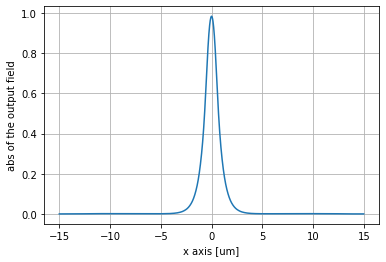

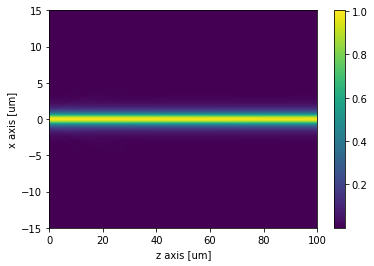

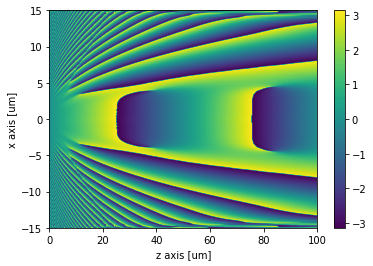

In [260]:
plt.plot(x_*1e6,np.abs(u))
plt.xlabel('x axis [um]')
plt.ylabel('abs of the input field')
plt.grid()
plt.show()

plt.plot(x_*1e6,np.abs(output))
plt.xlabel('x axis [um]')
plt.ylabel('abs of the output field')
plt.grid()
plt.show()

plt.imshow(np.abs(profile),aspect='auto',extent=[0,Lz_*1e6,-Lx_/2*1e6,Lx_/2*1e6])
plt.colorbar()
plt.xlabel('z axis [um]')
plt.ylabel('x axis [um]')
plt.show()

plt.imshow(np.angle(profile),aspect='auto',extent=[0,Lz_*1e6,-Lx_/2*1e6,Lx_/2*1e6])
plt.colorbar()
plt.xlabel('z axis [um]')
plt.ylabel('x axis [um]')
plt.show()